# Source Tracking Thesis

In [190]:
%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import glob
import csv
from os import path

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

path_root = '../matlab/mainczjs/evaluation/results/'
lms_red = (204/255, 53/255, 56/255)

def _get_trial_index(t):
    return ["t{}".format(i+1) for i in range(t)]

def _get_col_name(s,post):
    return sum([("x{}{},y{}{}".format(n,post,n,post)).split(',') for n in range(1,s+1)],[])

def _get_err_col_name(s):
    return ["err{}".format(n) for n in range(1,s+1)]

def get_col_names(s):
    return sum([_get_col_name(s,""), _get_col_name(s,"est"), _get_err_col_name(s)], []) 

def is_x1_correct(row):
    if abs(row["x1"]-row["x1est"]) > 0.001:
        if abs(row["y1"]-row["y1est"]) > 0.001:
            return 1
    return 0

## Evaluate Mean Error

In [206]:
eval_columns = ['n_trials', 'mean_err']
n_sources_range = [2, 3, 4, 5, 6, 7]
results_dict = {}
eval_index = n_sources_range
eval_data = pd.DataFrame(index=range(0,len(n_sources_range)),columns=eval_columns)
eval_data.index = eval_index

for s in n_sources_range:
    # define filename format
    files = glob.glob(path.join(path_root,"{}sources".format(s),'*.txt'))

    # load data
    dfs = []
    for f in files:
        dfs.append(pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float))
    results = pd.concat(dfs)
    n_trials = len(results)
    n_sources = int((len(results.columns)-1)/5)
    results.drop(results.columns[[n_sources*4+n_sources]], axis=1, inplace=True) 
    results.columns = get_col_names(n_sources)
    results.index = ["t{}".format(i+1) for i in range(n_trials)]
    results_dict['{}'.format(n_sources)] = results
    # preview data
    # print(results.sample(5))
    # print(results.sample(5).loc[:,'x1':'y2'])
    # print(results.sample(5).loc[:,"err1":])
    # print(results.loc[:,"err1":])
    
    # calculate statistics
    mean_err = results.mean()[-n_sources:].mean()
    # results.apply(is_x1_correct,axis=0)
    
    # saving statistics to eval_data
    eval_data.set_value(n_sources, 'n_trials', n_trials)
    eval_data.set_value(n_sources, 'mean_err', round(mean_err,3))
    
    # output statistics
    # print("# Sources: {}, # Trials: {}, Mean Error: {:0.2f}".format(n_sources, n_trials, mean_err))

### Plot results

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


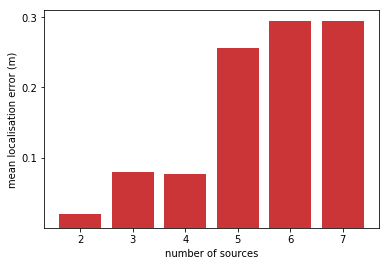

In [207]:
from matplotlib2tikz import save as tikz_save

plt.bar(eval_data.index, height=eval_data['mean_err'], color=lms_red)
# plt.xticks(["{} sources".format(x) for x in n_sources_range])
plt.xticks(n_sources_range)
plt.yticks([0.1, 0.2, 0.3])
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
# plt.title("Mean localisation error across number of sources")
# plt.show()
tikz_save('../latex/data/plots/mean-err-n-sources-bar.tex')

### Export results to LaTeX

In [213]:
eval_data.transpose().to_latex('../latex/data/tables/mean-err-n-sources.tex', column_format="rrrrrrr", bold_rows=True)
print(eval_data.transpose())

             2      3      4      5      6      7
n_trials    70     60     60     60     60     60
mean_err  0.02  0.079  0.077  0.256  0.295  0.294


### Boxplot

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


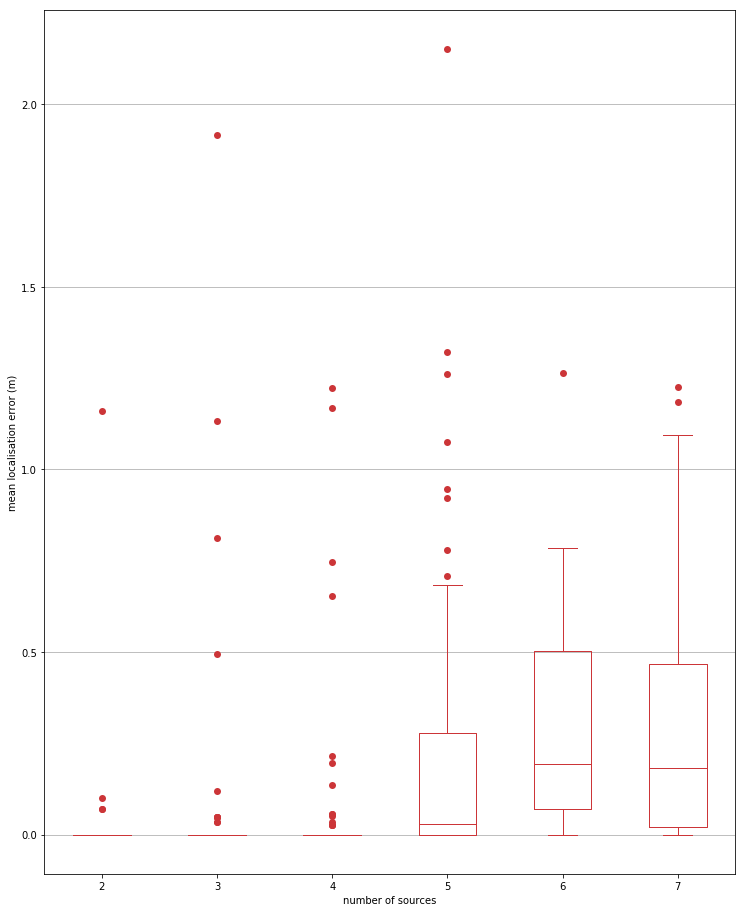

In [209]:
frames = []
total_trials = 0
for n_source, res in results_dict.items():
    df_err = pd.DataFrame(res.loc[:, 'err1':].mean(axis=1))
    df_source = pd.DataFrame(columns=['n'], index=_get_trial_index(len(res)), data=n_source)
    df_err['sources'] = df_source
    frames.append(df_err)
dfs = pd.concat(frames, ignore_index=True) # different indices
dfs.columns = ['err','sources']
bp = dfs.boxplot(by='sources',figsize=(12,16),return_type='both')

# style output
fig = bp[0].ax.get_figure()
for key in bp[0].lines.keys():
    for item in bp[0].lines[key]:
        item.set_color(lms_red)
for item in bp[0].lines['fliers']:
    item.set_markerfacecolor(lms_red)
    item.set_markeredgewidth(0)
    item.set_markeredgecolor(lms_red)
    item.set_markersize(7)


fig.suptitle('')
plt.title("")
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
plt.grid(axis='x')
tikz_save('../latex/data/plots/mean-err-n-sources-box.tex', show_info=False)




### Scatter Plot

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


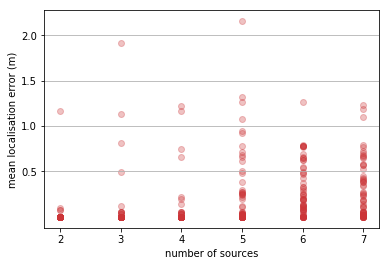

In [210]:
x = pd.to_numeric(dfs['sources'].values)  # without to_numeric(), tikz_save() fails (TypeError: str instead of int)
y = dfs['err'].values
plt.scatter(x, y, alpha=0.3, c=lms_red)
plt.xticks(n_sources_range)
plt.yticks([0.5, 1.0, 1.5, 2.0])
plt.grid(True, axis='y')
plt.xlabel("number of sources")
plt.ylabel("mean localisation error (m)")
# plt.show()
tikz_save('../latex/data/plots/mean-err-n-sources-scatter.tex', show_info=False)